## Example to run the vegetation grow model adapted to urban areas for multiple areas
#### The model runs based on a shapefile. In this simulation, 3 years of data are used. It is possible to run the model daily, but data stored from previous day is necessary for this case. 
#### For  more details of the model in Escobar-Silva et al. (2021)


In [17]:
#first, let's load the model and other necessary libraries. 
# **Geopandas must be installed

In [1]:
import sys
sys.path.insert(0, '../code') # use this to call the module from other folder
from uvgrowmodel import Growth_model as vgm
import pandas as pd
import geopandas as gpd
import numpy as np

In [18]:
#Let's load the weather data (one year of data).
#Necessary data:
#         - Date Field
#         - Min, Max and Mean Temperature
#         - Min, Max and Mean Relative Humidity
#         - Daily rain accumulation      
#Optional data:
#         - Solar Radiation (Rad)
#         - Evapotranspiration (ETo)

In [21]:
filename = r'..\data\weatherdata\Embrapa_daily_2020_366days.txt'

wdata = pd.read_csv(filename, skiprows=0,usecols=['Day','TMean','TMax','TMin','RHMean','RHMax','RHMmin',\
        'Rain','VMean','VMax','VDir','Rad','Eto'], sep=';', engine='python', parse_dates=True)
# Convert date to a readable unit
wdata['Day'] = pd.to_datetime(wdata.Day, format="%d-%m-%Y")

#just summarize the table to check if data is ok
wdata

,Day,TMean,TMax,TMin,RHMean,RHMax,RHMmin,Rain,VMean,VMax,VDir,Rad,Eto
0,2020-01-01,22.2,28.7,18.0,89.1,99.6,57.8,30.8,1.9,10.0,NE,16.73,3.03
1,2020-01-02,21.0,26.2,18.1,91.7,99.6,65.9,10.2,2.1,7.0,SE,14.53,2.54
2,2020-01-03,21.8,27.6,17.3,85.5,99.6,59.7,35.4,2.3,10.4,S,20.60,3.65
3,2020-01-04,21.1,28.8,17.7,91.4,99.6,56.3,13.2,2.1,10.7,NE,19.29,3.38
4,2020-01-05,22.2,28.5,17.2,88.1,99.6,55.5,4.2,1.6,9.2,N,24.49,4.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,17.9,18.4,17.5,99.5,99.5,99.4,30.8,1.2,6.4,L,11.73,1.92
362,2020-12-28,21.0,27.3,17.2,88.7,99.6,59.2,1.2,1.5,7.6,NE,19.07,3.46
363,2020-12-29,20.9,28.2,17.4,90.7,99.6,58.4,8.8,1.7,11.0,NE,21.03,3.77
364,2020-12-30,21.8,28.4,17.0,86.6,99.5,60.6,23.2,1.7,8.9,NE,23.23,4.26


In [22]:
# let's load now the shapefile with the areas. 
# HAND index column must be available or it may be calculated
# using the "HANDindex = np.exp(-1/20*HAND)" 
db = r'..\data\areas\shape_UFSCar.shp'
areas = gpd.read_file(db)

##### Now, let's run the model on each area and day, and apply the harvest/cutting based on a LAI threshold.
##### Larger values of HAND indicate more moisture available and lower indicate less. HAND should not be zero(0).

In [24]:
lst_dict = []
df1 = pd.DataFrame()
# do the analysis on the areas, it might take a while (reduce the number of polygons to do it faster)
for idx, area in areas.iterrows(): 
    HANDstr = area.Elev_exp
    for index, row in wdata.iterrows():
        if index == 0:
            VG = vgm(row.Day,row.TMin,row.TMax,row.TMean,
                            row.RHMean,row.Rain,ET0=row.Eto,UHAND=True,HAND=HANDstr)
            VG.plant_growth('SMI')
        else:
            #print(VG.drydays)
            VG = vgm(row.Day,row.TMin,row.TMax,row.TMean,
                        row.RHMean,row.Rain,LAI=VG.LAI,AHU=VG.AHU,ET0=row.Eto,FDAYS=VG.firstdayS,
                        FDAYW=VG.firstdayW,CANW=VG.Canopy_water,LAIdor=VG.LAIdor,FRMX=VG.fr_mx,
                        BIOM=VG.Biomass, AHUdor=VG.AHUdor,DD=VG.drydays,UHAND=True,HAND=HANDstr)

            #apply the cutting if LAI exceed a threshold
            if VG.LAI > 2:
                VG.cut_reset()
            VG.plant_growth('SMI')
            #print(VG)
        #append results to list
        lst_dict.append({'polID':area.name, 'Data':VG.Date, 'FRMX':VG.fr_mx,
                         'AHU': VG.AHU,'LAI': VG.LAI,'Biomass': VG.Biomass,
                         'W_str': VG.W_str,'ETP':VG.Etp,'DD':VG.drydays,
                         'T_str': VG.T_str,'R_str': VG.R_str,'Hand':area.Elev_exp})
    VG = None
#create a new dataframe with the results
df4 = df1.append(lst_dict)

In [25]:
#create a dataframe with the results
df4 = pd.DataFrame(lst_dict)
df4

,polID,Data,FRMX,AHU,LAI,Biomass,W_str,ETP,DD,T_str,R_str,Hand
0,0,2020-01-01,0.003453,11.2,0.805322,0.004638,0.768070,0.808000,0,0.700000,0.678325,0.399952
1,0,2020-01-02,0.006637,21.2,0.809976,0.008823,0.612430,0.681839,0,0.791367,0.677988,0.399952
2,0,2020-01-03,0.010185,32.0,0.814492,0.012007,0.841747,0.985470,0,0.693878,0.677616,0.399952
3,0,2020-01-04,0.013605,42.1,0.819829,0.016808,0.619570,0.917660,0,0.762238,0.677210,0.399952
4,0,2020-01-05,0.017516,53.3,0.826944,0.023367,0.600048,1.240674,0,0.662162,0.676769,0.399952
...,...,...,...,...,...,...,...,...,...,...,...,...
155545,424,2020-12-27,0.866859,1453.2,1.836230,0.642737,0.991889,1.174811,0,0.972414,0.679336,0.173569
155546,424,2020-12-28,0.869762,1463.2,1.840101,0.647867,0.826431,2.117785,0,0.743243,0.679133,0.173569
155547,424,2020-12-29,0.872579,1473.1,1.843736,0.652679,0.837293,2.312393,0,0.760274,0.678897,0.173569
155548,424,2020-12-30,0.875586,1483.9,1.845775,0.654006,0.955095,2.618105,0,0.680000,0.678628,0.173569


<Figure size 432x288 with 0 Axes>

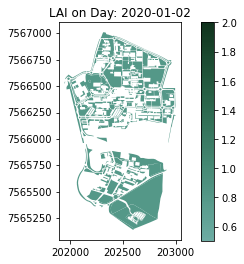

<Figure size 432x288 with 0 Axes>

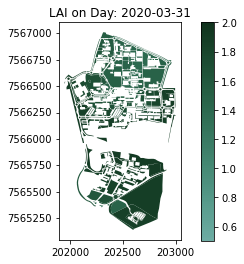

<Figure size 432x288 with 0 Axes>

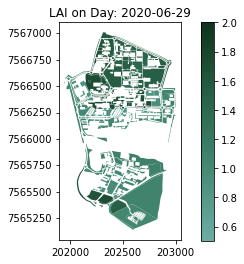

<Figure size 432x288 with 0 Axes>

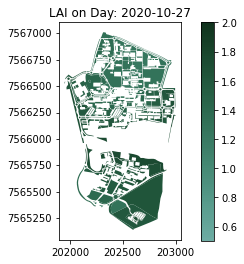

<Figure size 432x288 with 0 Axes>

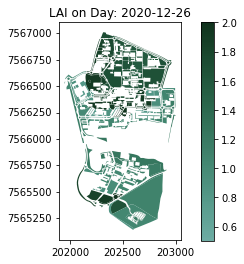

In [27]:
# Finally, we can plot the results to see if the model is working properly
## This needs Descartes package ##
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import seaborn as sns
pallete = sns.color_palette("ch:2,r=.2,l=.6",as_cmap=True)
fig = plt.figure()  
for day in df4.Data.unique()[[1,90,180,300,360]]: #selcting few days to plot
    group = df4.groupby('Data').get_group(day)
    areas['LAI'] = group.LAI.values
    plt.clf()
    mapa = areas.plot(column='LAI',cmap=pallete, vmin=0.5, vmax=2.,linewidth=0)
    plt.yticks(rotation=0,va='center')
    plt.title("LAI on Day: "+str(pd.to_datetime(np.datetime_as_string(day)).date()))
    fig = mapa.get_figure()
    cax = fig.add_axes([0.7, 0.12, 0.03, 0.76])
    sm = plt.cm.ScalarMappable(cmap=pallete, norm=plt.Normalize(vmin=0.5, vmax=2.))
    #sm._A = []
    fig.colorbar(sm, cax=cax)
    mapa.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    plt.show()
    # writer.grab_frame()
    # plt.pause(0.1)
plt.close()